# Mais uma 
O nome do arquivo já diz tudo. Dessa vez a transformação será baseada [neste notebook](https://github.com/Msanjayds/Kaggle_Projects/blob/master/1.%20Titanic%20Survival%20Prediction/Titanic_challenge.ipynb)

## Preparando o ambiente

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

## Carregando os dados

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/test.csv')

train.shape, test.shape

((891, 12), (418, 11))

## Analisando os dados

Criando uma classificação separada para quem morreu para facilitar a interpretação dos dados na análise.

In [3]:
data = train
data['Died']= 1 - data['Survived']

Análises sobre a morte de homens e de pessoas de meia idade já foi feita anteriormente. Destaco uma análise que não tinha sido feita: distribuição das mortes pelo valor pago na passagem.

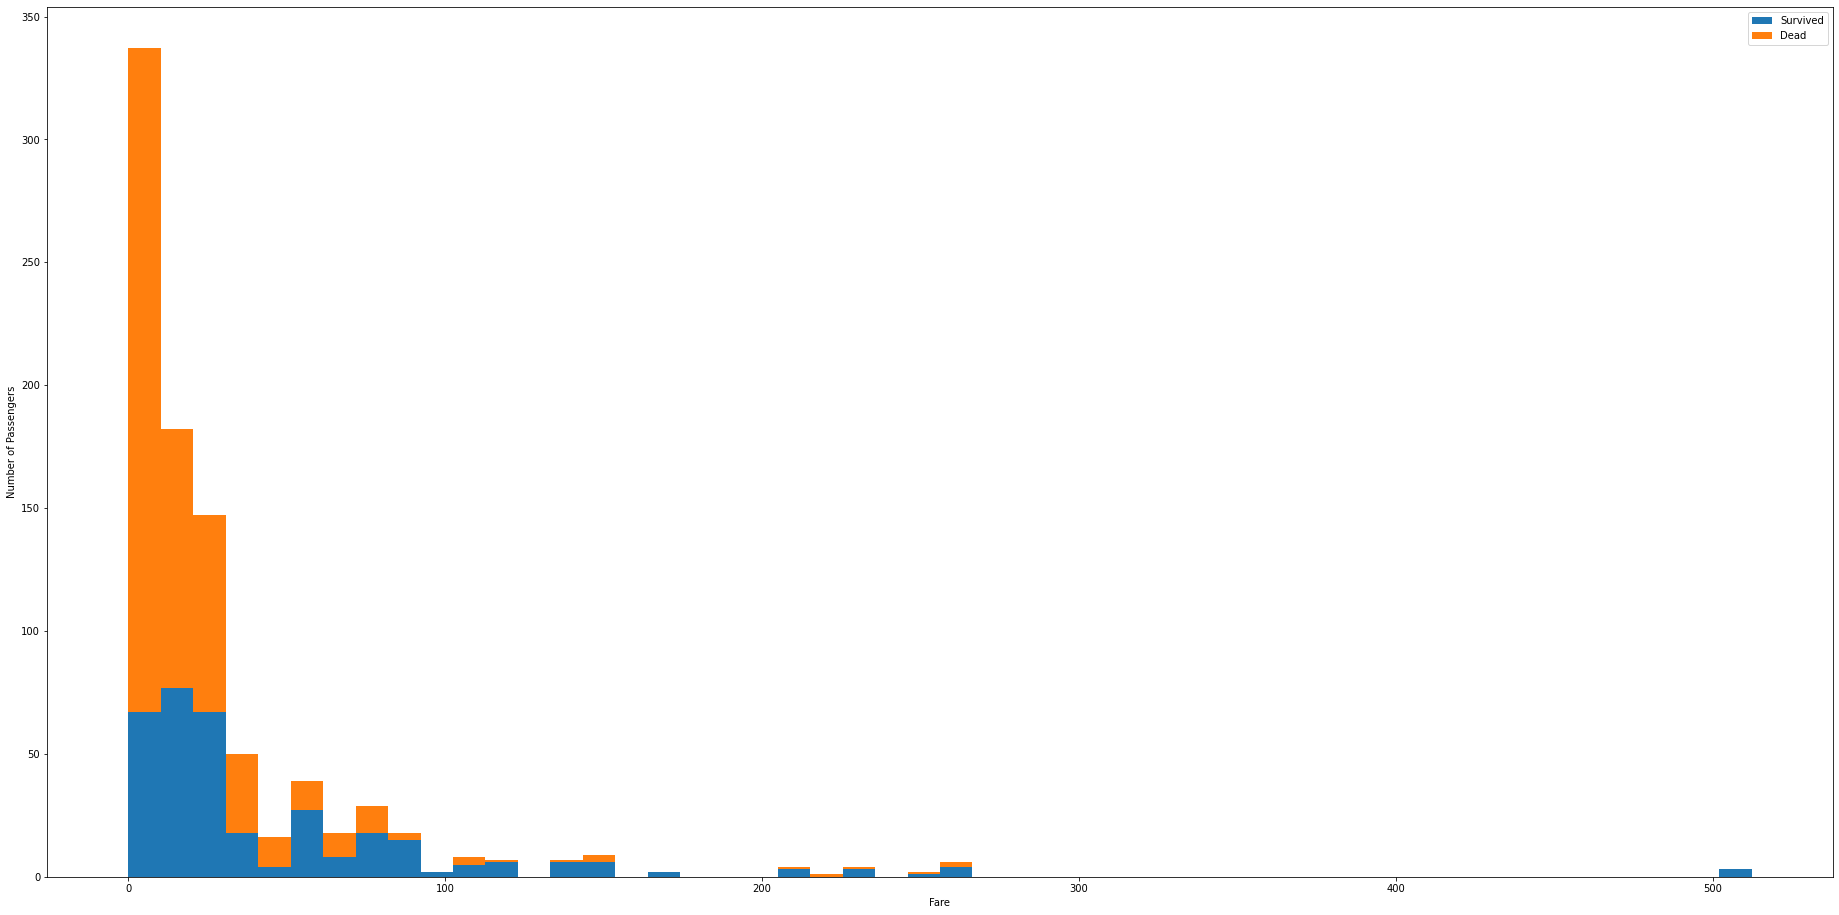

In [4]:
figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

Pessoas que pagaram um valor menor na passagem estão mais propensas a morrer, ainda que considerando o fato de que a maioria das pessoas pagou mais barato.

## Feature Engineering

In [5]:
x_train = train.drop(['Survived'],1)
y_train = train['Survived']
x_test = test

df_combined = x_train.append(x_test)
df_combined.shape

C:\Users\salat\AppData\Local\Temp/ipykernel_69984/1063705012.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train = train.drop(['Survived'],1)
C:\Users\salat\AppData\Local\Temp/ipykernel_69984/1063705012.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = x_train.append(x_test)


(1309, 12)

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_combined.tail().T)

,413,414,415,416,417
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Sex,male,female,male,male,male
Age,NaN,39.0,38.5,NaN,NaN
SibSp,0,0,0,0,1
Parch,0,0,0,0,1
Ticket,A.5. 3236,PC 17758,SOTON/O.Q. 3101262,359309,2668
Fare,8.05,108.9,7.25,8.05,22.3583
Cabin,NaN,C105,NaN,NaN,NaN


In [8]:
df_combined.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Died           float64
dtype: object

In [9]:
df_combined['Sex'] = df_combined['Sex'].astype('category')
df_combined.dtypes

PassengerId       int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
Died            float64
dtype: object

In [10]:
df_combined['Embarked'] = df_combined['Embarked'].astype('category')

In [11]:
display_all(df_combined.isnull().sum().sort_index()/len(df_combined))

Age            0.200917
Cabin          0.774637
Died           0.319328
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

In [12]:
df = df_combined.drop(columns=['Died'])
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
def process_family():
    
    global df
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

In [14]:
df = process_family()

In [15]:
def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    df.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [16]:
df = process_embarked()

In [17]:
def process_cabin():
    global df    
    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
#     status('cabin')
    return df

In [18]:
df = process_cabin()

In [19]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [20]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
#     status('Title')
    return df

In [21]:
df = get_titles()
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,2,...,1,0,0,0,0,0,0,0,1,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,...,0,0,0,1,0,0,0,0,0,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,1,...,1,0,0,0,0,0,0,0,1,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,...,1,0,0,1,0,0,0,0,0,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1,...,1,0,0,0,0,0,0,0,1,Mr


In [22]:
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [23]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Master,NaN
1,female,1,Miss,30.0
2,female,1,Mr,NaN
3,female,1,Mrs,45.0
4,female,1,Officer,49.0


In [24]:
#Assing the value of age for missing values based on the group.
#If a title is miising then the age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#     status('age')
    return df

In [27]:
df = process_age()

In [28]:
display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000764
LargeFamily    0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamily    0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

In [29]:
def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
#     status('names')
    return df

In [30]:
df = process_names()

In [37]:
def process_sex():
    global df

    name_map = {
        'female': 1,
        'male': 2
    }

    df['Sex'] = df['Sex'].map(name_map)

    return df

In [38]:
df = process_sex()
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Singleton,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,2,22.0,1,0,A/5 21171,7.2500,2,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,2,0,...,0,0,0,0,0,0,0,1,0,0
2,3,3,1,26.0,0,0,STON/O2. 3101282,7.9250,1,1,...,0,0,0,1,0,1,0,0,0,0
3,4,1,1,35.0,1,0,113803,53.1000,2,0,...,0,0,0,0,0,0,0,1,0,0
4,5,3,2,35.0,0,0,373450,8.0500,1,1,...,0,0,0,1,0,0,1,0,0,0


In [41]:
def process_ticket():
    global df

    df['Ticket'] = df['Ticket'].apply(lambda x: x[0:3])
    df['Ticket'] = df['Ticket'].astype('category')
    df['Ticket'] = df['Ticket'].cat.codes

    return df

In [ ]:
df = process_ticket()

In [45]:
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Singleton,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,2,22.0,1,0,139,7.2500,2,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,154,71.2833,2,0,...,0,0,0,0,0,0,0,1,0,0
2,3,3,1,26.0,0,0,165,7.9250,1,1,...,0,0,0,1,0,1,0,0,0,0
3,4,1,1,35.0,1,0,3,53.1000,2,0,...,0,0,0,0,0,0,0,1,0,0
4,5,3,2,35.0,0,0,108,8.0500,1,1,...,0,0,0,1,0,0,1,0,0,0


In [46]:
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

In [47]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

In [48]:
x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape

((891, 29), (418, 29))

In [49]:
x_train['Survived'] = y_train

In [50]:
x_train.to_csv('../../data/processed_v4/train.csv', index=False)
x_test.to_csv('../../data/processed_v4/test.csv', index=False)